# Covid-19 Time Series Modeling

- Flex
- Instructor: Morgan Jones
- Blog: [https://datascienceprojectsandmore.blogspot.com/](https://datascienceprojectsandmore.blogspot.com/)
- Date of Review: Tuesday, April 9th 2024

# Abstract

This project creates a model that forecasts the number of deaths by Covid-19 given the historical data.  The Covid-19 pandemic was detrimental in the number of people who perished from this disease.  The idea behind this project is that if we can create a predictive model that will forecast the amount of harm, then public health officials can be better informed, advised, and empowered to mitigate future deaths.  Specifically, this project focuses on a continent-wide evaluation, looking at Asia.

This project goes through a model iteration process, starting with a naive time series model, and iterating through ARIMA, multivariate ARIMA, Linear Regression, Facebook's Prophet, and multivariate prophet models.  The project finalizes on the multivariate prophet model as the final model based on the evaluation metric, root mean squared error, and evaluates this model on the holdout test set.  Lastly, the project offers a few recommendations to the proposed business and next steps for future projects.

- [GitHub README]()
- [non-technical presentation]()

# Introduction

## The Covid-19 Pandemic

![covid_map](images/covid_map.jpg)

The Covid-19 pandemic needs little introduction as it left no corner of our world untouched.  It devastated lives, and economies -- day-to-day life was dramatically altered for about 2-3 years.  During the pandemic, the World Health Organization, along with many other public health entities, concerned themselves with not only reacting to this public health crisis but also to recording and analyzing the data from the outbreak. This data accumulation was not only a way to evaluate the devastation and how different countries handled the situation, but also to be more informed and thus provide better recommendations or make more impactful decisions concerning public health. 

##  This Project | The Business + Business Problem

The specific business for this project is one akin to the World Health Organization (WHO) that 'treats data as a public good'([WHO Principles](https://data.who.int/about/data/who-data-principles), but also wants to leverage this data to make recommendations to public health officials.  The idea for this project is to create a model that will forecast how much worse the pandemic will be in order to advise public health officials and policy makers on how to best handle the situation such that damages are minimized.   

## The Data Source

The Data from this project is sourced directly from Kaggle, a dataset called [Our World in Data - COVID-19](https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset).  The company, [Our World in Data](https://ourworldindata.org/explorers/coronavirus-data-explorer) combined their own data along with data from the John Hopkins University and the WHO.  Further details on their data and sources can be found on the [GitHub page here](https://github.com/owid/covid-19-data/blob/master/public/data/README.md).

For visual purposes, the project also utilizes a dataset of latitude and longitude data of countries from Kaggle, originally sourced from google.  See that data set [here](https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state).

### Reproducing via Google CoLabs

If you are reproducing this project via Google CoLabs, please uncomment the two `!pip install` commands in the imports cell below, along with the 3 cells of code below the versions print outs.  The pip install commands will allow the use of pmdarima and Prophet libraries.  The three cells to uncomment will configure the Google CoLab environment to download the data sources from Kaggle, however **be sure to enter your own Kaggle username and API**, otherwise this cell will not work.  After configuring the cells download the two datasets and unzip them for further use.

In [1]:
# Import Needed Libraries

import json
import shutil
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.regression.linear_model import OLS

# For Google CoLab might need to install pmdarima and Prophet
#!pip install pmdarima
#!pip install Prophet

from pmdarima.arima import auto_arima
from prophet import Prophet

In [2]:
# Versions
import sys
import matplotlib
import sklearn
import statsmodels as sm
import prophet
import pmdarima

print('Python | ', sys.version[:5])
print('Pandas | ', pd.__version__)
print('Numpy | ', np.__version__)
print('SciPy | ', scipy.__version__)
print('Matplotlib | ', matplotlib.__version__)
print('Seaborn | ', sns.__version__)
print('Geopandas | ', gpd.__version__)
print('SciKit Learn | ', sklearn.__version__)
print('Stats Models | ', sm.__version__)
print('pmdarima | ', pmdarima.__version__)
print('Prophet | ', prophet.__version__)

Python |  3.8.5
Pandas |  1.1.3
Numpy |  1.24.4
SciPy |  1.10.1
Matplotlib |  3.3.1
Seaborn |  0.11.0
Geopandas |  0.13.2
SciKit Learn |  1.3.2
Stats Models |  0.14.1
pmdarima |  2.0.4
Prophet |  1.1.5


In [3]:
# Prep Google CoLab environment to download data from Kaggle
#!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json

#username = ''  ## Your Kaggle username
#api_key = ''  ## Your Kaggle API key

#api_token = {"username": username,
#             "key": api_key}

#with open('/root/.kaggle/kaggle.json', 'w') as file:
#    json.dump(api_token, file)

#!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset from Kaggle
#!kaggle datasets download -d caesarmario/our-world-in-data-covid19-dataset
#!kaggle datasets download -d paultimothymooney/latitude-and-longitude-for-every-country-and-state

In [5]:
# This cell unzips the downloaded data
#shutil.unpack_archive('our-world-in-data-covid19-dataset.zip', '/content')
#shutil.unpack_archive('latitude-and-longitude-for-every-country-and-state.zip', '/content')

# Data Exploration

First, we look at the complete data and find that there are quite a few redundancies in the accumulated data.  With the idea of modeling in mind, many of the columns are dropped.  For example, the data includes `total_cases`, `new_cases`, `new_cases_smoothed`, `new_cases_per_million`, and `new_cases_smoothed_per_million`.  For modeling, specifically for time series modeling, we are interested in the daily reports, and thus keep `new_cases_smoothed` because (a) smoothed data is better for seeing trends and (b) we want to work with the real data of the number of new cases that occurred each day.  This logic is applied to many of the variables in the original data set.  See below for a list of the variables kept and their definitions.  See also the [GitHub page](https://github.com/owid/covid-19-data/blob/master/public/data/README.md) for a full list of all the variables and their descriptions. 

Next, a visual of the countries in which the data is coming from is produced. The idea behind this is to try and see the best way to splice the data -- is it best by individual country, continent or by something else?  After looking at this map, it is decided to break up the data by continent and focus on Asia.  *(The original idea was to create models for each continent, but this project only had the bandwidth to look at one.  Future work would be to expand this to the other continents and compare.)* 

The project then transitions into a data cleaning phase in order to deal with the missing values in the Asia subset before looking at other 'data exploration' visuals.  The reasoning behind this is we want to explore the dataset that will be used in modeling; however this needs to be created by aggregating the Asia subset such that there is only one entry per day.  The missing values must be dealt with prior to aggregating.  See below for further details that occur during the Data Cleaning phase. 

Lastly, the project goes over some visuals for the aggregated Asia subset data that will be used for modeling.  

In [6]:
# Look at data
df = pd.read_csv('owid-covid-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350085 entries, 0 to 350084
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    350085 non-null  object 
 1   continent                                   333420 non-null  object 
 2   location                                    350085 non-null  object 
 3   date                                        350085 non-null  object 
 4   total_cases                                 312088 non-null  float64
 5   new_cases                                   340457 non-null  float64
 6   new_cases_smoothed                          339198 non-null  float64
 7   total_deaths                                290501 non-null  float64
 8   new_deaths                                  340511 non-null  float64
 9   new_deaths_smoothed                         339281 non-null  float64
 


| Columns | Description | 
|:--|:--| 
| `continent` | Continent of the geographical location | 
| `location` | Geographical location | 
| `date` | Date of observation | 
| `new_cases` | New confirmed cases of COVID-19. Counts can include probable cases, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA | 
| `new_cases_smoothed` | New confirmed cases of COVID-19 (7-day smoothed). Counts can include probable cases, where reported. | 
| `new_deaths` | New deaths attributed to COVID-19. Counts can include probable deaths, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA. |
| `new_deaths_smoothed` | New deaths attributed to COVID-19 (7-day smoothed). Counts can include probable deaths, where reported. |
| `reproduction_rate` | Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database | 
| `icu_patients` | Number of COVID-19 patients in intensive care units (ICUs) on a given day. |
| `hosp_patients` | Number of COVID-19 patients in hospital on a given day. |
| `new_tests` | New tests for COVID-19 (only calculated for consecutive days). |
| `new_tests_smoothed` | New tests for COVID-19 (7-day smoothed). For countries that don't report testing data on a daily basis, we assume that testing changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window |
| `positive_rate` | The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case). |
| `test_units` | Units used by the location to report its testing data. A country file can't contain mixed units. All metrics concerning testing data use the specified test unit. Valid units are 'people tested' (number of people tested), 'tests performed' (number of tests performed. a single person can be tested more than once in a given day) and 'samples tested' (number of samples tested. In some cases, more than one sample may be required to perform a given test.) | 
| `people_vaccinated` | Total number of people who received at least one vaccine dose | 
| `new_people_vaccinated_smoothed` | Daily number of people receiving their first vaccine dose (7-day smoothed) | 
| `new_vaccinations` | New COVID-19 vaccination doses administered (only calculated for consecutive days) | 
| `new_vaccinations_smoothed` | New COVID-19 vaccination doses administered (7-day smoothed). For countries that don't report vaccination data on a daily basis, we assume that vaccination changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window |
| `total_boosters` | Total number of COVID-19 vaccination booster doses administered (doses administered beyond the number prescribed by the vaccination protocol) |
| `stringency_index` | Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response). | 
| `population_density` | Number of people divided by land area, measured in square kilometers, most recent year available | 
| `median_age` | Median age of the population, UN projection for 2020 | 
| `aged_70_older` | Share of the population that is 70 years and older in 2015 |
| `gdp_per_capita` | Gross domestic product at purchasing power parity (constant 2011 international dollars), most recent year available | 
| `extreme_poverty` | Share of the population living in extreme poverty, most recent year available since 2010 | 
| `cardiovasc_death_rate` | Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people) | 
| `diabetes_prevalence` | Dabetes prevalence (% of population aged 20 to 79) in 2017 |
| `female_smokers` | Share of women who smoke, most recent year available | 
| `male_smokers` | Share of men who smoke, most recent year available | 
| `handwashing_facilities` | Share of the population with basic handwashing facilities on premises, most recent year available |
| `hospital_beds_per_thousand` | Hospital beds per 1,000 people, most recent year available since 2010 |
| `life_expectancy` | Life expectancy at birth in 2019 | 
| `human_development_index` | A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506 | 
| `population` | Population (latest available values). See https://github.com/owid/covid-19-data/blob/master/scripts/input/un/population_latest.csv for full list of sources | 



In [7]:
# Choose which columns to use/drop
cols_to_use = ['continent', 'location', 'date', 'new_cases_smoothed', 'new_deaths_smoothed',
               'reproduction_rate', 'icu_patients', 'hosp_patients', 'new_tests_smoothed', 
               'positive_rate', 'tests_units', 'people_vaccinated', 'new_people_vaccinated_smoothed',
               'total_boosters', 'new_vaccinations_smoothed', 'stringency_index', 'population_density', 
               'median_age', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
               'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 
               'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'population']
df1 = df[cols_to_use]

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350085 entries, 0 to 350084
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   continent                       333420 non-null  object 
 1   location                        350085 non-null  object 
 2   date                            350085 non-null  object 
 3   new_cases_smoothed              339198 non-null  float64
 4   new_deaths_smoothed             339281 non-null  float64
 5   reproduction_rate               184817 non-null  float64
 6   icu_patients                    37615 non-null   float64
 7   hosp_patients                   38902 non-null   float64
 8   new_tests_smoothed              103965 non-null  float64
 9   positive_rate                   95927 non-null   float64
 10  tests_units                     106788 non-null  object 
 11  people_vaccinated               75911 non-null   float64
 12  new_people_vacci

In [9]:
# Update date variable to datetime
df1['date'] = pd.to_datetime(df1['date'])

<ipython-input-9-ff5bda607d92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.to_datetime(df1['date'])


In [10]:
# Import latitude & longitude data
lat_long = pd.read_csv('world_country_and_usa_states_latitude_and_longitude_values.csv')
lat_long = lat_long[['latitude', 'longitude', 'country']]
lat_long.head()

,latitude,longitude,country
0,42.546245,1.601554,Andorra
1,23.424076,53.847818,United Arab Emirates
2,33.939110,67.709953,Afghanistan
3,17.060816,-61.796428,Antigua and Barbuda
4,18.220554,-63.068615,Anguilla


In [11]:
# merge dataframes so can visualize
df2 = pd.merge(df1,
              lat_long,
              left_on='location',
              right_on='country',
              how='left')

In [12]:
# Drop not countries
loc_to_drop = ['Africa', 'Asia', 'Europe', 'European Union', 'High income', 
               'Low income', 'Lower middle income', 'North America', 'Oceania', 
               'South America', 'Upper middle income', 'World']

df2 = df2[~df2['location'].isin(loc_to_drop)]

<ipython-input-13-940db7fa8124>:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


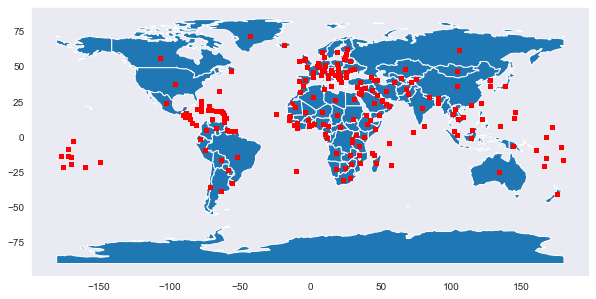

In [13]:
# Visualize where, which countries, the data is coming from
    # See https://stackoverflow.com/a/53233489 for source

geometry = [Point(xy) for xy in zip(df2['longitude'], df2['latitude'])]
gdf = GeoDataFrame(df2[['longitude', 'latitude']], geometry=geometry)   

# A simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Based on the above graph on where the data is coming from -- the most logical and least inhibited route will be to consolidate the data by continent. 

In [14]:
# Drop non-countries from df1
df1 = df1[~df1['location'].isin(loc_to_drop)]

In [15]:
# sanity check
df1['continent'].isna().sum()

0

In [16]:
# What are all the continents present
df1['continent'].unique()

array(['Asia', 'Europe', 'Africa', 'Oceania', 'North America',
       'South America'], dtype=object)

In [17]:
# Create the different dataframes that we will use for modeling

df_asia = df1[df1['continent'] == 'Asia']
df_eu = df1[df1['continent'] == 'Europe']
df_af = df1[df1['continent'] == 'Africa']
df_oc = df1[df1['continent'] == 'Oceania']
df_na = df1[df1['continent'] == 'North America']

df_sa = df1[df1['continent'] == 'South America']

In [18]:
# Look at the total number of missing values by continent

data = [('Asia', df_asia), ('Europe', df_eu), ('Africa', df_af), 
        ('Oceana', df_oc), ('North America', df_na), ('South America', df_sa)]

for (name, df) in data:
    nulls = df.isna().sum().sum()
    print(name, nulls)

Asia 610565
Europe 764416
Africa 759079
Oceana 515862
North America 792359
South America 185857


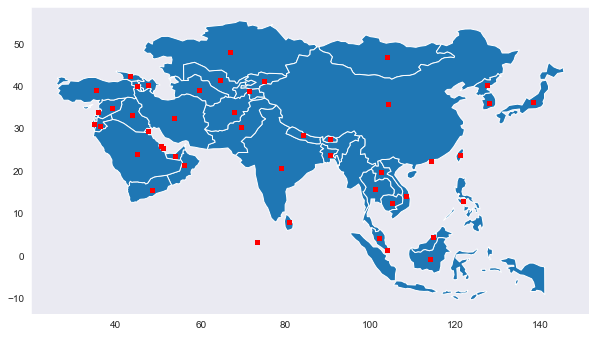

In [19]:
# Visualize the countries working with in the Asia subset

df2_asia = df2[df2['continent'] == 'Asia']

geometry = [Point(xy) for xy in zip(df2_asia['longitude'], df2_asia['latitude'])]
gdf = GeoDataFrame(df2_asia[['longitude', 'latitude']], geometry=geometry)

asia = world[world['continent'] == 'Asia']
gdf.plot(ax=asia.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

## Data Cleaning 

In the below section the project handles the missing values. We first take a look at what percent of each variable is missing as well as what percent of each country is missing before looking at a visual of the number of missing values by variable by date.  This, along with the context of each variable, gives us an idea of how to appropriate deal with the missing values.  See below for the details 

#### Train/Validate/Test Split? 

The true train, validate, test split will occur after we aggregate the data to one row per day entry.  However, we do want to keep this split in mind to avoid any unnecessary data leakage.     

In [20]:
# Look at dates where train, validate, test split will be

unique_dates_total = len(df_asia['date'].unique())
first_80_perc = unique_dates_total * .8
train_end = df_asia['date'].unique()[int(first_80_perc)]
print('Last train date:', train_end)

val_perc = first_80_perc + (unique_dates_total * .1)
val_end = df_asia['date'].unique()[int(val_perc)]
print('Last validation date:', val_end)

Last train date: 2023-01-19T00:00:00.000000000
Last validation date: 2023-06-07T00:00:00.000000000


In [21]:
# Check percent missing by variable
num_rows = len(df_asia['date'])
for var in df_asia.columns:
    missing = df_asia[var].isna().sum()
    if missing > 0:
        print(var, '{}%'.format(round(missing/num_rows*100, 1)))

new_cases_smoothed 6.4%
new_deaths_smoothed 6.4%
reproduction_rate 33.9%
icu_patients 94.9%
hosp_patients 96.0%
new_tests_smoothed 61.2%
positive_rate 64.5%
tests_units 60.5%
people_vaccinated 75.0%
new_people_vaccinated_smoothed 44.4%
total_boosters 86.9%
new_vaccinations_smoothed 44.3%
stringency_index 26.4%
population_density 4.9%
median_age 1.0%
aged_70_older 1.0%
gdp_per_capita 6.9%
extreme_poverty 44.0%
cardiovasc_death_rate 4.0%
diabetes_prevalence 6.1%
female_smokers 24.0%
male_smokers 24.0%
handwashing_facilities 48.0%
hospital_beds_per_thousand 10.0%
life_expectancy 1.0%
human_development_index 6.1%


In [22]:
# Check percent missing by country
for country in df_asia['location'].unique():
    mask = df_asia['location'] == country
    num_cells = len(df_asia[mask]) * 30
    missing = df_asia[mask].isna().sum().sum()
    percent = round(missing/num_cells*100, 1)
    if percent > 40:
        print(country, '{}%'.format(percent))

Hong Kong 47.2%
Macao 58.1%
North Korea 53.2%
Northern Cyprus 80.2%
Syria 47.3%
Taiwan 54.7%


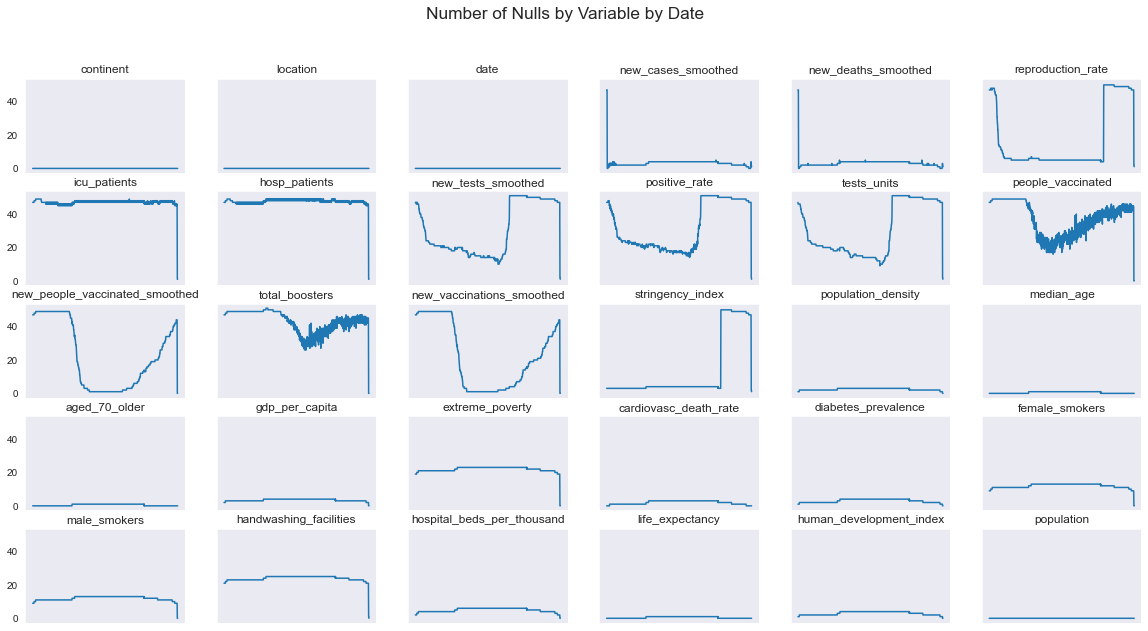

In [23]:
# Visualize number of missing values by variable by date

fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(20,10), sharey=True, sharex=True)

for i,var in enumerate(df_asia.columns):
    y = []
    for date in df_asia['date'].unique():
        y.append(df_asia[df_asia['date'] == date][var].isna().sum())
    
    row = i // 6
    col = i % 6
    ax = axes[row, col]   
    
    ax.plot(df_asia['date'].unique(), y)
    ax.set_title(var)
    ax.set_xticks([])
plt.suptitle('Number of Nulls by Variable by Date', fontsize='xx-large');

Based on the above information, we will move forward with:
- Dropping the below as too much data is missing:
    - Country: Northern Cyrus, Macao, and Hong Kong (while not quite 50% missing, Hong Kong is missing quite a lot and is a small regional area -- can be lumped in with China). 
    - Variables: `icu_patients`, `hosp_patients`, `new_tests_smoothed`, `positive_rate`, `tests_units`, `total_boosters`, 
- Furthermore Dropping:
    - `reproduction_rate` -- as the value cannot be appropriately estimated in the validation and test sets when a vast majority of the countries stopped reporting on this value.
    - `new_people_vaccinated_smoothed` -- as we will use new vaccinations smoothed instead.
- Drop the below as they will be constant for every day (thus not useful for time series modeling):
    - `population_density`, `median_age`, `aged_70_older`, `gdp_per_capita`, `extreme_poverty`, `cardiovasc_death_rate`, `diabetes_prevalence`, `female_smokers`, `male_smokers`, `handwashing_facilities`, `hospital_beds_per_thousand`, `life_expectancy`, `human_development`

In [24]:
# Drop countries
mask = (df_asia['location'] == 'Northern Cyprus') | (df_asia['location'] == 'Hong Kong') | (df_asia['location'] == 'Macao')
df_asia = df_asia[~mask]
    
# Drop variables
col_to_drop = ['icu_patients', 'hosp_patients', 'new_tests_smoothed', 'positive_rate', 'tests_units', 'reproduction_rate',
              'new_people_vaccinated_smoothed', 'total_boosters', 'extreme_poverty', 'handwashing_facilities',
              'population_density', 'gdp_per_capita', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 
              'hospital_beds_per_thousand', 'human_development_index']

df_asia = df_asia.drop(col_to_drop, axis=1)

In [25]:
# Recheck missing values be variable
num_rows = len(df_asia['date'])
for var in df_asia.columns:
    missing = df_asia[var].isna().sum()
    if missing > 0:
        print(var, '{}%'.format(round(missing/num_rows*100, 1)))

new_cases_smoothed 2.5%
new_deaths_smoothed 2.4%
people_vaccinated 76.0%
new_vaccinations_smoothed 45.6%
stringency_index 25.9%


In [26]:
# Recheck missing values by country
for country in df_asia['location'].unique():
    mask = df_asia['location'] == country
    num_cells = len(df_asia[mask]) * 30
    missing = df_asia[mask].isna().sum().sum()
    percent = round(missing/num_cells*100, 1)
    if percent > 20:
        print(country, '{}%'.format(percent))

| Variable | How to Handel missing values | 
|:---|:--|
| `new_cases_smoothed` | Input 0.  NaN only entered when negative values present due to corrective reporting. | 
| `new_deaths_smoothed` | Input 0. NaN only entered when negative values present due to corrective reporting. | 
| `people_vaccinated` | Forward fill for missing values after vaccine released by country. | 
| `new_vaccinations_smoothed` | Input 0. Missing values prior to vaccine release date are 0. Assume no new vaccinations or reporting error for NaN values after vaccine date. | 
| `stringency_index` | By country, forward fill. Assuming a missing value means it was not reported and no change between previous assigned value. For validation & test sets with no information to forward, assume 0 value (many Covid-19 policies ended in 2023).| 

In [27]:
# Input 0 for assigned columns
    # True for train, validate, and test groups -- no need to split
fill_values = {'new_cases_smoothed' : 0, 'new_deaths_smoothed':0, 'new_vaccinations_smoothed':0}
df_asia.fillna(fill_values, inplace=True)

In [28]:
# People Vaccinated -- Forward fill by country (start with 0)

# Start with 0
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country)
    mask2 = (df_asia['date'] == (df_asia.loc[mask, 'date'].unique().min()))
    mask_all = mask & mask2
    df_asia.loc[mask_all, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].fillna(0)

# Train Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] < train_end)
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].ffill()
    if df_asia.loc[mask, 'people_vaccinated'].isna().sum() > 0:
        print('train', country)
        
# Validation Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= train_end) & (df_asia['date'] < val_end)
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].ffill()  
    if df_asia.loc[mask, 'people_vaccinated'].isna().sum() > 0:
        print('val', country)
        
# Test Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= val_end)
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].ffill()  
    if df_asia.loc[mask, 'people_vaccinated'].isna().sum() > 0:
        print('test', country)
        

val Afghanistan
val Armenia
val Azerbaijan
val Bahrain
val Bangladesh
val Bhutan
val Brunei
val Cambodia
val Georgia
val Indonesia
val Iran
val Iraq
val Jordan
val Kazakhstan
val Kuwait
val Laos
val Lebanon
val Maldives
val Mongolia
val Myanmar
val Nepal
val North Korea
val Oman
val Pakistan
val Palestine
val Qatar
val Saudi Arabia
val Sri Lanka
val Syria
val Taiwan
val Tajikistan
val Thailand
val Timor
val Turkey
val Turkmenistan
val United Arab Emirates
val Uzbekistan
val Vietnam
val Yemen
test Afghanistan
test Armenia
test Azerbaijan
test Bahrain
test Bhutan
test Brunei
test China
test Georgia
test India
test Indonesia
test Iran
test Iraq
test Israel
test Japan
test Jordan
test Kazakhstan
test Kuwait
test Laos
test Lebanon
test Maldives
test Mongolia
test Myanmar
test Nepal
test North Korea
test Oman
test Pakistan
test Palestine
test Philippines
test Qatar
test Saudi Arabia
test Singapore
test South Korea
test Sri Lanka
test Syria
test Taiwan
test Tajikistan
test Thailand
test Timor

Three options here: 

1. Back fill from known values in Validation + Test Sets 
   - This would avoid any data leakage from the training set into the validation + test sets but not be quite as accurate 

2. Forward fill information from train set into validation + test sets 
    - This would be much more accurate (this is a cumulative value per country and thus be the more accurate approach, but would mean data leakage is occurring. 

3. Drop the variable 

In [29]:
# Try back filling

# Validation Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= train_end) & (df_asia['date'] < val_end)
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].bfill()  
    if df_asia.loc[mask, 'people_vaccinated'].isna().sum() > 0:
        print('val', country)
        
# Test Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= val_end)
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].bfill()  
    if df_asia.loc[mask, 'people_vaccinated'].isna().sum() > 0:
        print('test', country)

val Azerbaijan
val Bahrain
val Bhutan
val Georgia
val Iraq
val Jordan
val Kazakhstan
val Laos
val Lebanon
val Mongolia
val North Korea
val Oman
val Palestine
val Sri Lanka
val Thailand
val Turkey
val United Arab Emirates
test Azerbaijan
test Bahrain
test Bhutan
test China
test Georgia
test Indonesia
test Iraq
test Israel
test Japan
test Jordan
test Kazakhstan
test Laos
test Lebanon
test Maldives
test Mongolia
test Myanmar
test North Korea
test Oman
test Palestine
test Philippines
test Qatar
test Saudi Arabia
test Singapore
test South Korea
test Sri Lanka
test Syria
test Tajikistan
test Thailand
test Turkey
test United Arab Emirates


In [30]:
# That did not work -- rather than dropping the variable we will forward fill completely. 
    # Yes this will mean a bit of data leakage, but it is reasonable to assume that if we knew the previous number of total
    # people vaccinated that this number will be the same moving forward if no new reports/updates made (no new vaccinations)
        
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) 
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].ffill()
    
df_asia['people_vaccinated'].isna().sum()

0

In [31]:
# stringency_index
df_asia['stringency_index'].isna().sum()

17235

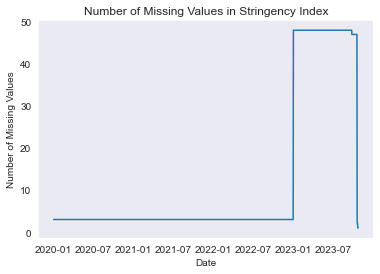

In [32]:
# Look at when the missing values for stringency_index are
y = []
for date in df_asia['date'].unique():
    y.append(df_asia[df_asia['date'] == date]['stringency_index'].isna().sum())
    
fig, ax = plt.subplots()
ax.plot(df_asia['date'].unique(), y)
ax.set_title('Number of Missing Values in Stringency Index')
ax.set_ylabel('Number of Missing Values')
ax.set_xlabel('Date');

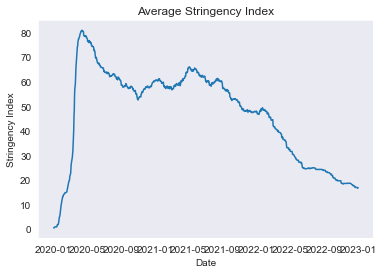

In [33]:
# Look at average stringency_index by date
y = []
for date in df_asia['date'].unique():
    avg = np.mean(df_asia[df_asia['date'] == date]['stringency_index'])
    y.append(avg)

fig, ax = plt.subplots()
ax.plot(df_asia['date'].unique(), y)
ax.set_title('Average Stringency Index')
ax.set_ylabel('Stringency Index')
ax.set_xlabel('Date');

In [34]:
# Forward Fill nulls

# Train Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] < train_end)
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].ffill()
    if df_asia.loc[mask, 'stringency_index'].isna().sum() > 0:
        print('train', country)
        
# Validation Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= train_end) & (df_asia['date'] < val_end)
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].ffill()  
    if df_asia.loc[mask, 'stringency_index'].isna().sum() > 0:
        print('val', country)
        
# Test Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= val_end)
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].ffill()  
    if df_asia.loc[mask, 'stringency_index'].isna().sum() > 0:
        print('test', country)

train Armenia
train Maldives
train North Korea
val Afghanistan
val Armenia
val Azerbaijan
val Bahrain
val Bangladesh
val Bhutan
val Brunei
val Cambodia
val China
val Georgia
val India
val Indonesia
val Iran
val Iraq
val Israel
val Japan
val Jordan
val Kazakhstan
val Kuwait
val Kyrgyzstan
val Laos
val Lebanon
val Malaysia
val Maldives
val Mongolia
val Myanmar
val Nepal
val North Korea
val Oman
val Pakistan
val Palestine
val Philippines
val Qatar
val Saudi Arabia
val Singapore
val South Korea
val Sri Lanka
val Syria
val Taiwan
val Tajikistan
val Thailand
val Timor
val Turkey
val Turkmenistan
val United Arab Emirates
val Uzbekistan
val Vietnam
val Yemen
test Afghanistan
test Armenia
test Azerbaijan
test Bahrain
test Bangladesh
test Bhutan
test Brunei
test Cambodia
test China
test Georgia
test India
test Indonesia
test Iran
test Iraq
test Israel
test Japan
test Jordan
test Kazakhstan
test Kuwait
test Kyrgyzstan
test Laos
test Lebanon
test Malaysia
test Maldives
test Mongolia
test Myanmar
t

In [35]:
# So we have three countries where the stringency index was never reported, and, as seen with `people_vaccinated`, 
    # most countries stopped reporting on this value starting in 2023.

# For the countries that never reported we will put the average for the day in -- this value will be averaged in aggregate

for date in df_asia.loc[df_asia['date']<train_end,'date'].unique():
    
    if df_asia[df_asia['date'] == date]['stringency_index'].isna().sum() > 0:
        avg = np.mean(df_asia[df_asia['date'] == date]['stringency_index'])
        
        for country in df_asia[df_asia['stringency_index'].isna()]['location'].unique():
            mask = (df_asia['location'] == country) & (df_asia['date'] == date)
            df_asia.loc[mask, 'stringency_index'].fillna(avg)

For the Validation + test sets again, some options: 

1. Back fill from known values in Validation + Test Sets (although as we saw above this might not work if ALL values are missing for each country. 
2. Forward fill information from train set into validation + test sets 
    - This would be much more accurate (this is a cumulative value per country and thus be the more accurate approach, but would mean data leakage is occurring. 

3. Input 0 for this variable in Validation + Test Sets 
    - This is reasonable only because we know that most countries dropped most if not all of their Covid-19 protections by 2023. 
4. Drop the variable 

In [36]:
# We will try option 1 and if that fails move to option 3

# Try backfilling:
# Validation Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= train_end) & (df_asia['date'] < val_end)
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].bfill()  
    if df_asia.loc[mask, 'stringency_index'].isna().sum() > 0:
        print('val', country)
        
# Test Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= val_end)
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].bfill()  
    if df_asia.loc[mask, 'stringency_index'].isna().sum() > 0:
        print('test', country)

val Afghanistan
val Armenia
val Azerbaijan
val Bahrain
val Bangladesh
val Bhutan
val Brunei
val Cambodia
val China
val Georgia
val India
val Indonesia
val Iran
val Iraq
val Israel
val Japan
val Jordan
val Kazakhstan
val Kuwait
val Kyrgyzstan
val Laos
val Lebanon
val Malaysia
val Maldives
val Mongolia
val Myanmar
val Nepal
val North Korea
val Oman
val Pakistan
val Palestine
val Philippines
val Qatar
val Saudi Arabia
val Singapore
val South Korea
val Sri Lanka
val Syria
val Taiwan
val Tajikistan
val Thailand
val Timor
val Turkey
val Turkmenistan
val United Arab Emirates
val Uzbekistan
val Vietnam
val Yemen
test Afghanistan
test Armenia
test Azerbaijan
test Bahrain
test Bangladesh
test Bhutan
test Brunei
test Cambodia
test China
test Georgia
test India
test Indonesia
test Iran
test Iraq
test Israel
test Japan
test Jordan
test Kazakhstan
test Kuwait
test Kyrgyzstan
test Laos
test Lebanon
test Malaysia
test Maldives
test Mongolia
test Myanmar
test Nepal
test North Korea
test Oman
test Pakis

In [37]:
# Check if still nulls present
df_asia['stringency_index'].isna().sum()

16425

In [38]:
# That clearly did not work -- move forward with filling nulls with 0 for 2023 onwards (validation + test sets)
df_asia['stringency_index'] = df_asia['stringency_index'].fillna(0)

In [39]:
# Sanity Check
df_asia['stringency_index'].isna().sum()

0

In [40]:
# Check Total Missing Values
df_asia.isna().sum().sum()

0

## Aggregate Data + Explore

The next subsection aggregates the data such that there is one row per day.  This will give us an overall average of Asia as a continent and allow us to make general predictions and recommendations on a larger geographical scale. 

The project then goes on and looks at each variable against time, both as the aggregate value and by individual country to further comprehend what data we are working with. 

In [116]:
# Look at data
df_asia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66452 entries, 0 to 347314
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   continent                  66452 non-null  object        
 1   location                   66452 non-null  object        
 2   date                       66452 non-null  datetime64[ns]
 3   new_cases_smoothed         66452 non-null  float64       
 4   new_deaths_smoothed        66452 non-null  float64       
 5   people_vaccinated          66452 non-null  float64       
 6   new_vaccinations_smoothed  66452 non-null  float64       
 7   stringency_index           66452 non-null  float64       
 8   median_age                 66452 non-null  float64       
 9   aged_70_older              66452 non-null  float64       
 10  cardiovasc_death_rate      66452 non-null  float64       
 11  life_expectancy            66452 non-null  float64       
 12  pop

| Variable | How to aggregate |
|:--|:--|
|`continent` | drop |
| `location` | drop |
| `date` | unique value per day | 
| `new_cases_smoothed` | sum per day |
| `new_deaths_smoothed` | sum per day |
| `people_vaccinated` | sum per day (cumulative value) |
| `new_vaccinations_smoothed` | sum per day |
| `stringency_index` | average per day |

In [42]:
# Dictionary to create new data frame for time series
asia_ts_data = {}
asia_ts_data['date'] = df_asia['date'].unique()

# Average per day
avg_daily = ['stringency_index']

for var in avg_daily:
    values_to_add = []
    
    for date in df_asia['date'].unique():
        mask = df_asia['date'] == date
        avg = np.mean(df_asia.loc[mask, var])
        values_to_add.append(avg)
        
    asia_ts_data[var] = values_to_add
    
# Sum per day
sum_daily = ['new_cases_smoothed', 'new_deaths_smoothed', 'people_vaccinated', 'new_vaccinations_smoothed']

for var in sum_daily:
    values_to_add = []
    
    for date in df_asia['date'].unique():
        mask = df_asia['date'] == date
        sum_ = np.sum(df_asia.loc[mask, var])
        values_to_add.append(sum_)
        
    asia_ts_data[var] = values_to_add        

In [43]:
# Create new dataframe
df_asia_ts = pd.DataFrame(asia_ts_data)
df_asia_ts.set_index('date', inplace=True)

In [119]:
df_asia_ts.loc['2020-12-20':'2021-01-15']

,stringency_index,new_cases_smoothed,new_deaths_smoothed,people_vaccinated,new_vaccinations_smoothed
date,,,,,
2020-12-20,55.092292,100734.858,1451.858,7468.0,194897.0
2020-12-21,55.227500,99427.855,1463.000,32391.0,203660.0
2020-12-22,55.709583,97227.430,1446.570,77060.0,213163.0
2020-12-23,55.825417,94578.716,1437.002,178942.0,223827.0
2020-12-24,55.979583,92404.430,1428.714,263483.0,242625.0
2020-12-25,56.047083,90790.141,1438.287,302473.0,236616.0
2020-12-26,56.162917,88234.286,1420.572,336104.0,233688.0
2020-12-27,56.336667,85441.143,1396.000,442739.0,247035.0
2020-12-28,56.278750,82840.140,1377.430,580902.0,262315.0


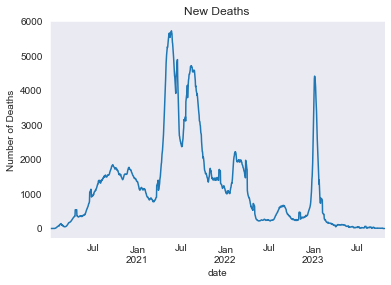

In [45]:
# Look at new_deaths_smoothed -- our target variable!
fig, ax = plt.subplots()
df_asia_ts['new_deaths_smoothed'].plot(ax=ax)
ax.set_title('New Deaths')
ax.set_ylabel('Number of Deaths');

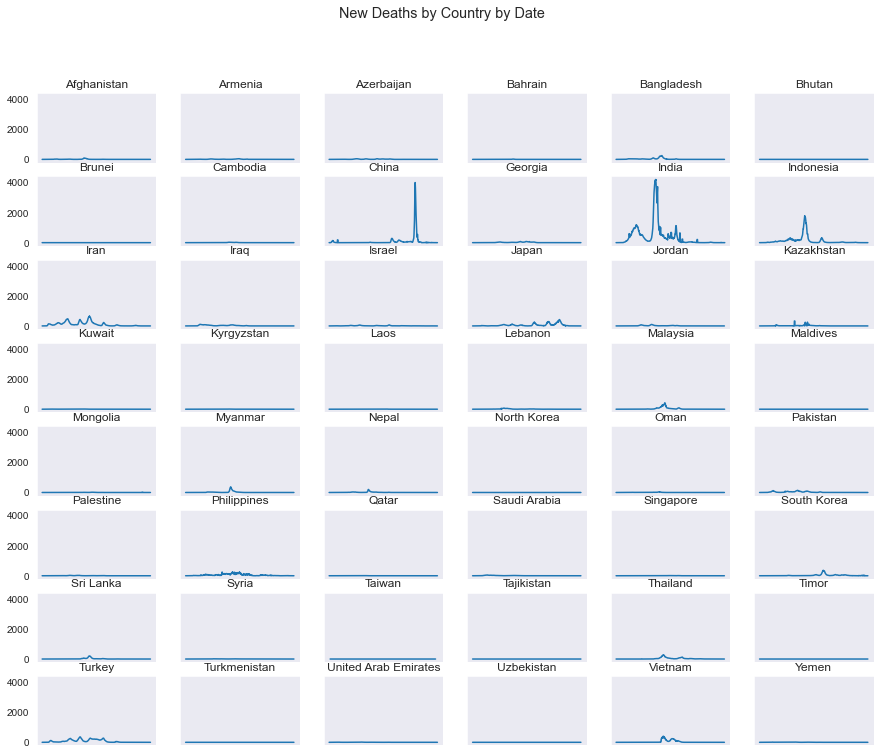

In [46]:
# Look at new_deaths_smoothed by country
fig, axes = plt.subplots(ncols=6, nrows=8, figsize=(15,12), sharey=True, sharex=True)

for i,country in enumerate(df_asia['location'].unique()):
    row = i // 6 
    col = i % 6
    ax = axes[row, col]
    
    mask = df_asia['location'] == country
    x = df_asia.loc[mask, 'date'].unique()
    y = df_asia.loc[mask, 'new_deaths_smoothed']
    
    ax.plot(x, y)
    ax.set_title(country)
    ax.set_xticks([])
plt.suptitle('New Deaths by Country by Date', fontsize='x-large');

- The spike in China in January 2023 is due to the end of 'zero COVID' standard.
- The spike in India in June of 2021 is due in part to the Delta Variant that was rampant at the time.
- Even with these known explanations for the spikes we are seeing, they are still notable outliers. 

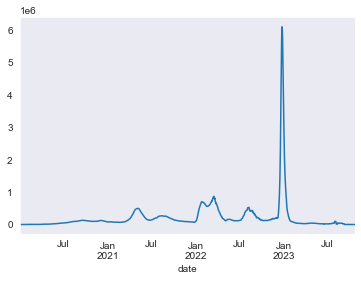

In [47]:
# Look at new_cases_smoothed aggregated
df_asia_ts['new_cases_smoothed'].plot();

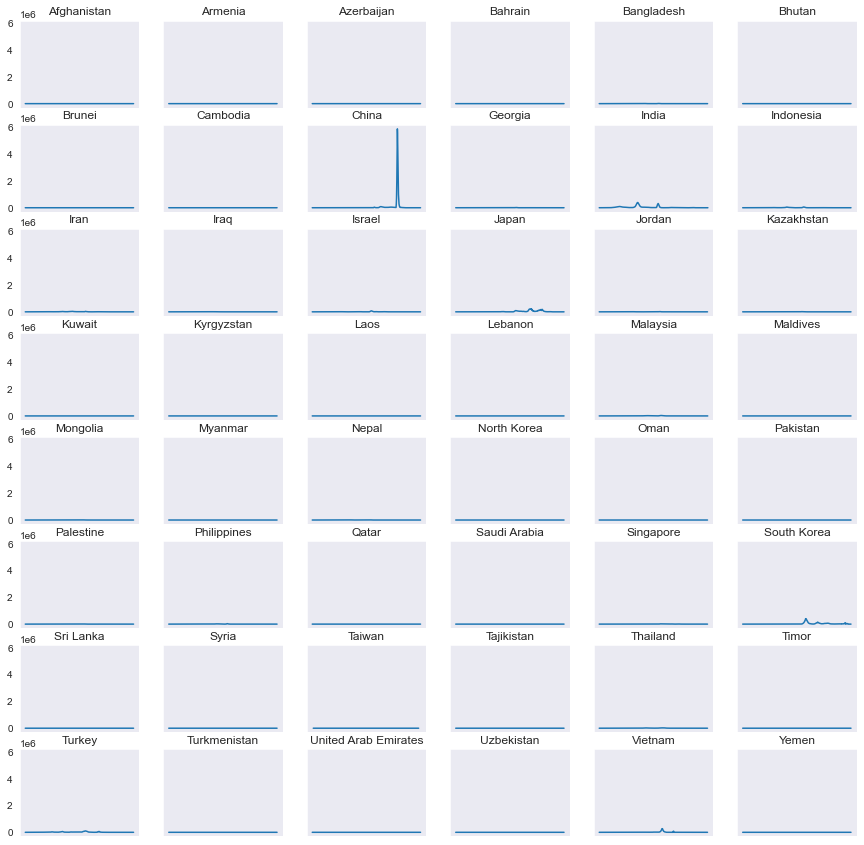

In [48]:
# Look at new_cases_smoothed by country

fig, axes = plt.subplots(ncols=6, nrows=8, figsize=(15,15), sharey=True, sharex=True)

for i,country in enumerate(df_asia['location'].unique()):
    row = i // 6 
    col = i % 6
    ax = axes[row, col]
    
    mask = df_asia['location'] == country
    x = df_asia.loc[mask, 'date'].unique()
    y = df_asia.loc[mask, 'new_cases_smoothed']
    
    ax.plot(x, y)
    ax.set_title(country)
    ax.set_xticks([]);

Again, we can attribute this spike seen in 2023 in China to the end of 'Zero-Covid' policies.

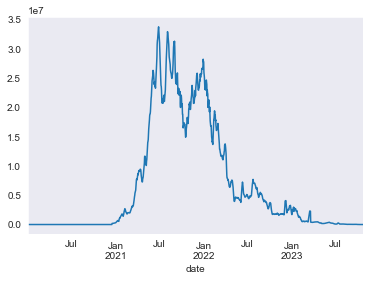

In [49]:
# Look at new_vaccinations_smoothed aggregated
df_asia_ts['new_vaccinations_smoothed'].plot();

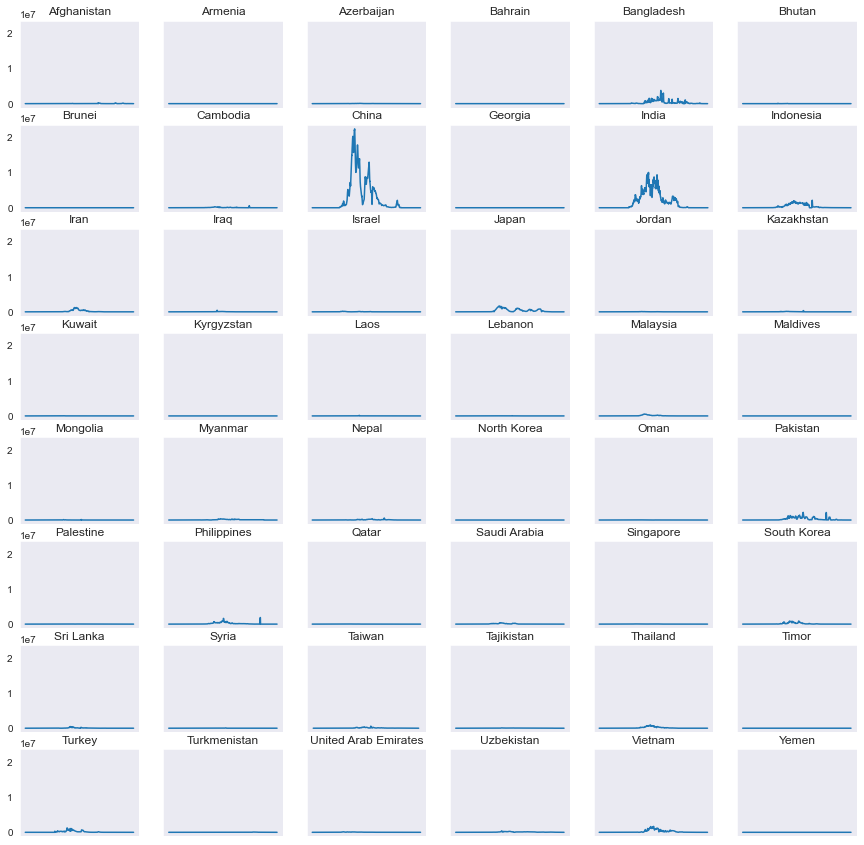

In [50]:
# Look at new_vaccinations smoothed by country

fig, axes = plt.subplots(ncols=6, nrows=8, figsize=(15,15), sharey=True, sharex=True)

for i,country in enumerate(df_asia['location'].unique()):
    row = i // 6 
    col = i % 6
    ax = axes[row, col]
    
    mask = df_asia['location'] == country
    x = df_asia.loc[mask, 'date'].unique()
    y = df_asia.loc[mask, 'new_vaccinations_smoothed']
    
    ax.plot(x, y)
    ax.set_title(country)
    ax.set_xticks([]);

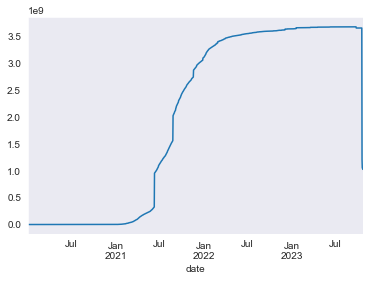

In [51]:
# Look at people_vaccinated aggreggated
df_asia_ts['people_vaccinated'].plot();

That is an unusual trend at the end there that we would not expect to see as this is a cumulative value -- it should never be smaller than its previous value.  Let's investigate this further and fix.

In [52]:
# Look at the last 8 days in the dataset
df_asia_ts['people_vaccinated'][-8:]

date
2023-10-16    3.656579e+09
2023-10-17    3.656579e+09
2023-10-18    3.656579e+09
2023-10-19    1.207039e+09
2023-10-20    1.055535e+09
2023-10-21    1.055535e+09
2023-10-22    1.027419e+09
2023-10-23    1.027419e+09
Name: people_vaccinated, dtype: float64

In [53]:
# Some countries must not have data for the last 5 days which is causing the averages to produce unexpected 
# Will move forward with using the value found on the 18th as the last value for these 5 days.

list_ = []
list_.append(df_asia_ts['people_vaccinated'][-8])
list_ = list_ * 5
df_asia_ts['people_vaccinated'][-5:] = list_

df_asia_ts['people_vaccinated'][-8:]

date
2023-10-16    3.656579e+09
2023-10-17    3.656579e+09
2023-10-18    3.656579e+09
2023-10-19    3.656579e+09
2023-10-20    3.656579e+09
2023-10-21    3.656579e+09
2023-10-22    3.656579e+09
2023-10-23    3.656579e+09
Name: people_vaccinated, dtype: float64

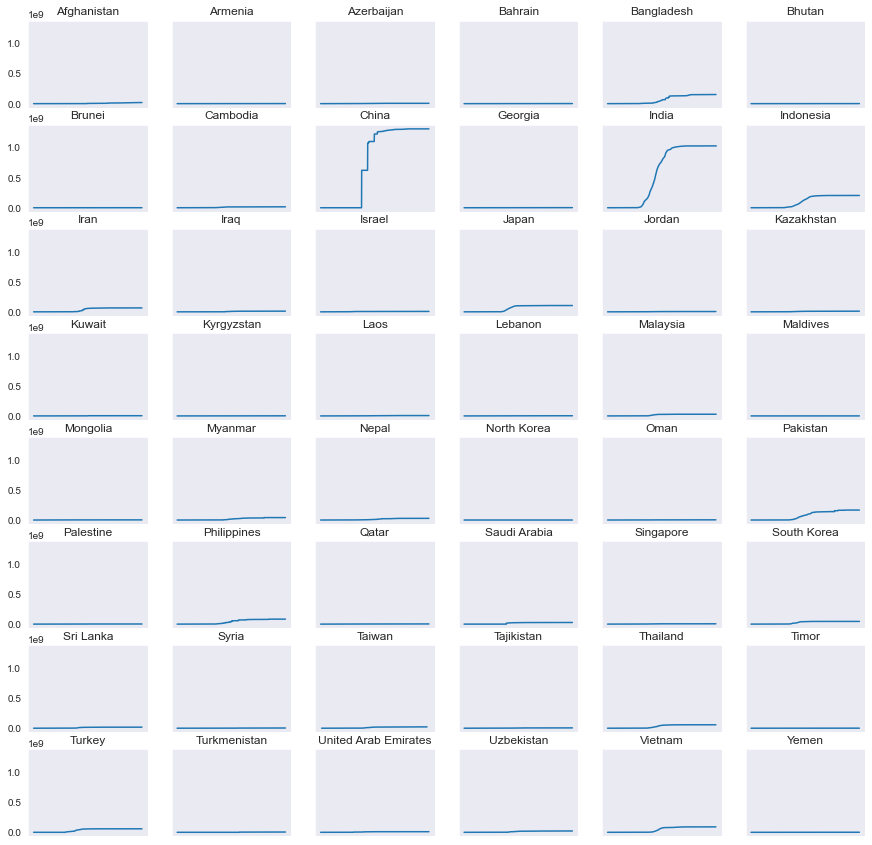

In [54]:
# Look at people_vaccinated by country
fig, axes = plt.subplots(ncols=6, nrows=8, figsize=(15,15), sharey=True, sharex=True)

for i,country in enumerate(df_asia['location'].unique()):
    row = i // 6 
    col = i % 6
    ax = axes[row, col]
    
    mask = df_asia['location'] == country
    x = df_asia.loc[mask, 'date'].unique()
    y = df_asia.loc[mask, 'people_vaccinated']
    
    ax.plot(x, y)
    ax.set_title(country)
    ax.set_xticks([]);

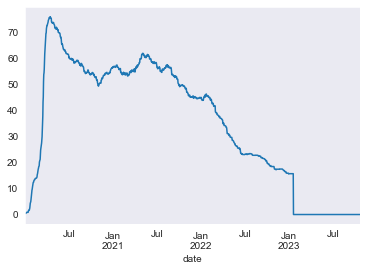

In [55]:
# Look at stringency_index aggregated
df_asia_ts['stringency_index'].plot();

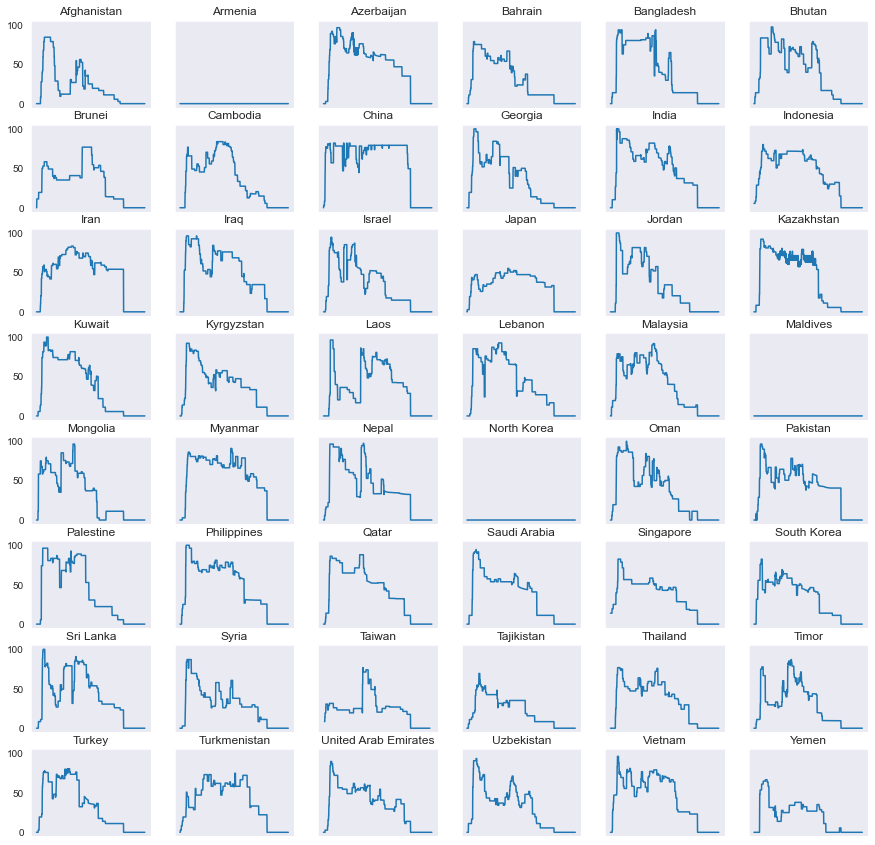

In [56]:
# Look at stringency_index by country
fig, axes = plt.subplots(ncols=6, nrows=8, figsize=(15,15), sharey=True, sharex=True)

for i,country in enumerate(df_asia['location'].unique()):
    row = i // 6 
    col = i % 6
    ax = axes[row, col]
    
    mask = df_asia['location'] == country
    x = df_asia.loc[mask, 'date'].unique()
    y = df_asia.loc[mask, 'stringency_index']
    
    ax.plot(x, y)
    ax.set_title(country)
    ax.set_xticks([]);

# Modeling

The project goes through various different models:

1. Naive Model (Baseline)
2. ARIMA (using auto_arima to find best parameters)
3. Multivariate ARIMA
4. Linear Regression
5. Prophet 
6. Multivariate Prophet

Each model makes a prediction for the validation set dates, and then is evaluated with the root mean squared error. Each model is compared using this error prior to choosing the final model to evaluate with the test set.

### Train/Validate/Test Split

In [57]:
print('Train set will consist of approximately the first {} dates'.format(len(df_asia_ts.index) * .8))
print('Validate set will consist of approximately the next {} dates'.format(len(df_asia_ts.index) * .1))
print('Test set will consist of approximately the last {} dates'.format(len(df_asia_ts.index) * .1))

Train set will consist of approximately the first 1112.0 dates
Validate set will consist of approximately the next 139.0 dates
Test set will consist of approximately the last 139.0 dates


In [58]:
# Train Set
first_80_perc = len(df_asia_ts.index) * .8
mask = df_asia_ts.index[:int(first_80_perc)]
train = df_asia_ts.loc[mask]
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1112 entries, 2020-01-03 to 2023-01-18
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   stringency_index           1112 non-null   float64
 1   new_cases_smoothed         1112 non-null   float64
 2   new_deaths_smoothed        1112 non-null   float64
 3   people_vaccinated          1112 non-null   float64
 4   new_vaccinations_smoothed  1112 non-null   float64
dtypes: float64(5)
memory usage: 52.1 KB


In [59]:
# Validate Set
val_perc = 139 + int(first_80_perc)
mask = df_asia_ts.index[int(first_80_perc):val_perc]
validate = df_asia_ts.loc[mask]
validate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 2023-01-19 to 2023-06-06
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   stringency_index           139 non-null    float64
 1   new_cases_smoothed         139 non-null    float64
 2   new_deaths_smoothed        139 non-null    float64
 3   people_vaccinated          139 non-null    float64
 4   new_vaccinations_smoothed  139 non-null    float64
dtypes: float64(5)
memory usage: 6.5 KB


In [60]:
# Test Set
mask = df_asia_ts.index[val_perc:]
test = df_asia_ts.loc[mask]
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 2023-06-07 to 2023-10-23
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   stringency_index           139 non-null    float64
 1   new_cases_smoothed         139 non-null    float64
 2   new_deaths_smoothed        139 non-null    float64
 3   people_vaccinated          139 non-null    float64
 4   new_vaccinations_smoothed  139 non-null    float64
dtypes: float64(5)
memory usage: 6.5 KB


## Baseline -- Naive Model

The Naive Method is to predict that the value tomorrow will be the same value that is seen today.  Thus we will shift our data by one for our 'predictions'.  We also look a bit further into our data, looking at the rolling standard deviation and variance of the residuals prior to forecasting  for the validation dates and evaluating the RMSE.

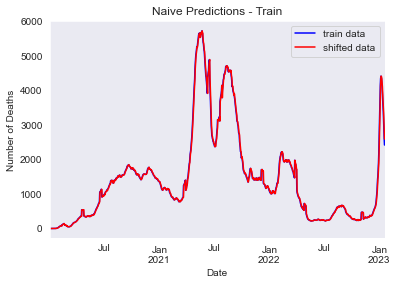

In [61]:
# The Naive "Model"
baseline = train['new_deaths_smoothed'].shift(1)

# Visualize f
fig, ax = plt.subplots()

train['new_deaths_smoothed'].plot(ax=ax, c='b', label='train data')
baseline.plot(ax=ax, c='r', label='shifted data')
ax.set_title('Naive Predictions - Train')
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Date')
ax.legend();

In [62]:
# Train RMSE
baseline_error_train = np.sqrt(mean_squared_error(train['new_deaths_smoothed'][1:], 
                                                  baseline.dropna()))
baseline_error_train

74.98148522286566

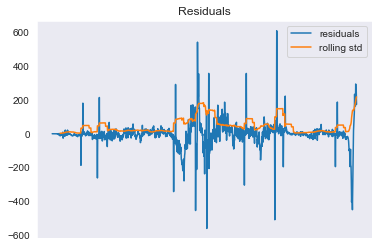

In [63]:
# look for trends -- want residuals to look like white noise
fig, ax = plt.subplots()

residuals = baseline[1:] - train['new_deaths_smoothed'][1:]
ax.plot(residuals.index, residuals, label='residuals')
ax.plot(residuals.index, residuals.rolling(30).std(), label='rolling std')
ax.set_xticks([])
ax.set_title('Residuals')
ax.legend();

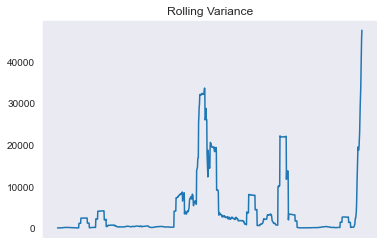

In [64]:
# check variance
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals.rolling(30).var())
ax.set_xticks([])
ax.set_title('Rolling Variance');

In [65]:
# "Predict" -- use last known data point for all future predictions
y_preds_baseline = []
y_preds_baseline.append(baseline[-1])
y_preds_baseline = y_preds_baseline * len(validate.index)

# For evaluation, assign y_train and y_val
y_train = train['new_deaths_smoothed']
y_val = validate['new_deaths_smoothed']

In [66]:
def graph_preds(train_data, validate_data, predictions, model_name):
    """
    This function takes in the values the model was trained on, and the true validation values, 
    both as pandas series with the date as the index. It also takes in the predictions as a list 
    or pandas series, and graphs all three on a single axis.
    """

    fig, ax = plt.subplots()

    validate_data.plot(ax=ax, color='b', label='validation data')
    train_data.plot(ax=ax, color='g', label='train data')
    ax.plot(validate_data.index, predictions, color='r', label='prediction')
    ax.set_title(model_name + ' Predictions')
    ax.set_ylabel('Number of Deaths')
    ax.set_xlabel('Date')
    ax.legend();

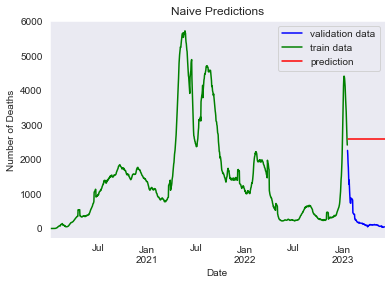

In [67]:
# Visualize
graph_preds(y_train, y_val, y_preds_baseline, 'Naive')

In [68]:
# Record Evaluation Results

all_results = {'model': [], 'rmse':[]}

def evaluate(y_true, y_pred, all_results, model_name):
    """
    This function takes in a y_true, y_pred, a dictionary called all_results, and a model name. 
    It calculates the RMSE, prints it, and appends it and the model_name to the appropriate dictionary key.
    """
    # RMSE
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(model_name, 'RMSE', round(rmse, 1))
    
    # Add to dictionary
    all_results['model'].append(model_name)
    all_results['rmse'].append(rmse)

In [69]:
# RMSE
evaluate(y_val, y_preds_baseline, all_results, 'Naive')

Naive RMSE 2342.6


## Model 2 - ARIMA

Before jumping into the auto_arima function which performs a grid-search-like function internally to achieve the optimal p, d, and q values, we take a look at the ACF and PACF graphs (for both the original data as well as the once differenced data) to better understand the time series data.  We also visualize the differenced data and perform a Dickey-Fuller test to ascertain whether or not the differenced data is stationary. 

After that manual work, we move forward into utilizing the auto_arima function which does that work for us.  The model is created and then evaluated.

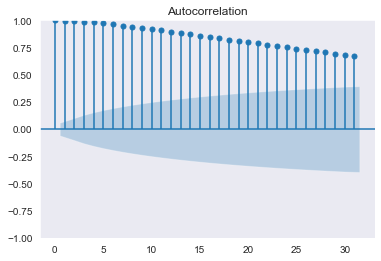

In [70]:
# ACF
fig, ax = plt.subplots()
plot_acf(train['new_deaths_smoothed'], ax=ax);

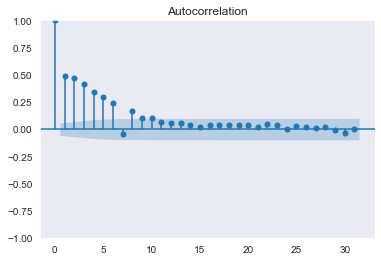

In [71]:
# Take the first difference -- now plot ACF
fig, ax =  plt.subplots()
data = train['new_deaths_smoothed'].diff().dropna()
plot_acf(data, ax=ax);

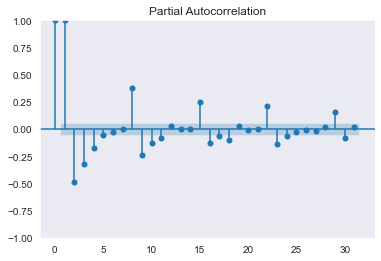

In [72]:
# PACF (correlation between current time periord + lags 
    # accounting for the correlation between the intermediate time periods)
fig, ax = plt.subplots()
plot_pacf(train['new_deaths_smoothed'], ax=ax, method='ols-adjusted');

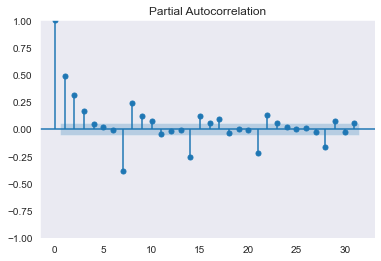

In [73]:
# PACF of differenced data
fig, ax =  plt.subplots()
data = train['new_deaths_smoothed'].diff().dropna()
plot_pacf(data, ax=ax, method='ols-adjusted');

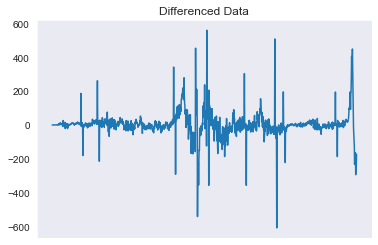

In [74]:
# Visualize Differenced Data
fig, ax = plt.subplots()
ax.plot(train['new_deaths_smoothed'].diff().dropna())
ax.set_title('Differenced Data')
ax.set_xticks([]);

In [75]:
# Check if the once differenced data is stationary

p_val = adfuller(train['new_deaths_smoothed'].diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")

if p_val < 0.05:
    print("Thus we can safely assume that the differenced data is stationary.")
else:
    print("Thus we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 1.8312712742959405e-06,
Thus we can safely assume that the differenced data is stationary.


Based on the adjusted Dickey-Fuller test, we can assert that the once differenced data is stationary which means it is suitable for modeling.  However, based on the ACF and PACF visuals, even of the differenced data, we know we will need to include some autoregressive (AR) and moving average (MA) terms.

Let's also take a look at the data once again to see if we should include any seasonality terms in our model.

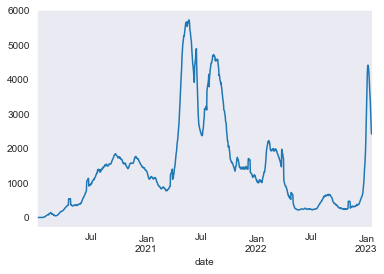

In [76]:
# Look for seasonality trends
y_train.plot();

There does not appear to be any seasonality trends present in our data (on the weekly, monthly, nor yearly scale).  We will move forward with excluding these features from our model. 

In [77]:
# auto_arima function parameters -- values chosen + notes

# time series to train on + predict
y_train = train['new_deaths_smoothed']
# no constants
X_train = train[['new_cases_smoothed', 'people_vaccinated', 'new_vaccinations_smoothed', 'stringency_index']]

# AR term
start_p = 1
max_p = 5 # default

# Order of non-seasonal first-differencing
d=None # default -- calculated
max_d = 2 # default -- from above we know 1 difference is stationary 

# MA term
start_q = 1
max_q = 5 #default

# Seasonality 
seasonal = False 

# Evaluaton to select best ARIMA model
information_criterion = 'aic' # default

# Level of significance
alpha = 0.05 # default

# Scoring default is MSE

In [78]:
# ARIMA Model
arima = auto_arima(y_train, start_p=start_p, start_q=start_q, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12319.179, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12748.856, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12450.579, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12571.953, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12747.791, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12309.801, Time=0.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12337.492, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12308.240, Time=1.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12308.637, Time=0.36 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12309.883, Time=1.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12275.377, Time=2.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12306.198, Time=0.83 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.90 sec
 ARIMA(1,1,3)(0,0,0)[0] interce

In [79]:
# Future dates to forecast
n_periods_pred = validate['new_deaths_smoothed'].shape[0]

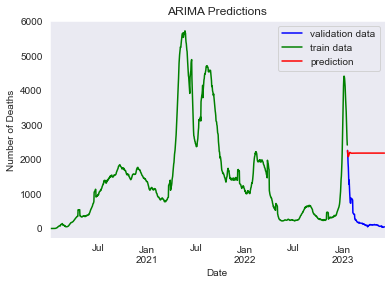

In [80]:
# Predict
y_preds_arima = arima.predict(n_periods=n_periods_pred)

# Visualize
graph_preds(y_train, y_val, y_preds_arima, 'ARIMA')

In [81]:
# RMSE
evaluate(y_val, y_preds_arima, all_results, 'ARIMA')

ARIMA RMSE 1943.7


## Model 3 - Multivariate ARIMA

Rather than just use the target variable, the true 'time series' data of `new_deaths_smoothed`, we will incorporate the other variables that we have available to us. 

In [82]:
# Multivariate ARIMA model
arima_multi = auto_arima(y_train, X_train, start_p=start_p, start_q=start_q, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12292.082, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12725.721, Time=1.84 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12419.089, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12555.246, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19405.347, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12274.985, Time=1.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12300.733, Time=1.00 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12273.326, Time=1.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12270.068, Time=1.34 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=12269.356, Time=1.64 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=12270.779, Time=1.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12271.600, Time=1.83 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=12273.016, Time=1.89 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=12267.357, Time=1.45 sec
 ARIMA(3,1,0)(0,0,0

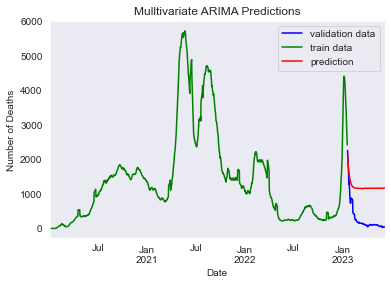

In [83]:
# predict
X_val = validate[['new_cases_smoothed', 'people_vaccinated', 'new_vaccinations_smoothed', 'stringency_index']]
y_preds_arima_multi = arima_multi.predict(n_periods=n_periods_pred, X=X_val)

#visualize
graph_preds(y_train, y_val, y_preds_arima_multi, 'Mulltivariate ARIMA')

In [84]:
# RMSE
evaluate(y_val, y_preds_arima_multi, all_results, 'ARIMA Multivariate')

ARIMA Multivariate RMSE 968.2


## Model 4 - Linear Regresion

While Linear Regressions are typically not suited for time series data, there is no harm in trying it out.

In [85]:
# Create + fit the model
lr = OLS(y_train, sm.api.add_constant(X_train))
lr_results = lr.fit()

In [86]:
# Look at summary of model
print(lr_results.summary())

                             OLS Regression Results                            
Dep. Variable:     new_deaths_smoothed   R-squared:                       0.575
Model:                             OLS   Adj. R-squared:                  0.573
Method:                  Least Squares   F-statistic:                     374.2
Date:                 Mon, 08 Apr 2024   Prob (F-statistic):          7.63e-204
Time:                         07:08:06   Log-Likelihood:                -9094.1
No. Observations:                 1112   AIC:                         1.820e+04
Df Residuals:                     1107   BIC:                         1.822e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

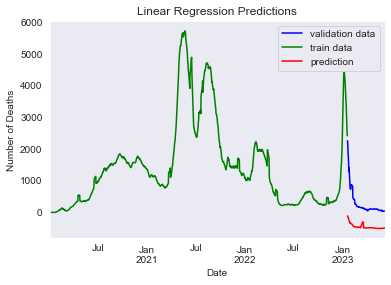

In [87]:
# predict
y_preds_lr = lr_results.predict(sm.api.add_constant(X_val))

# Visualize
graph_preds(y_train, y_val, y_preds_lr, 'Linear Regression')

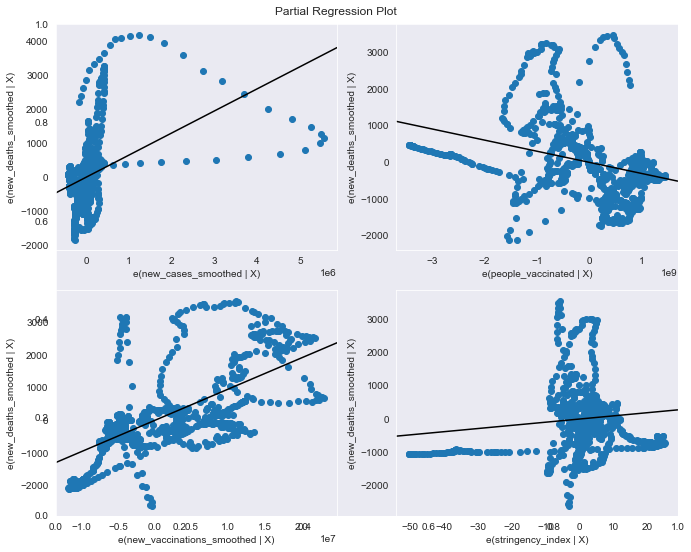

In [88]:
# Look at the partial regression grid for our variables
fig, ax = plt.subplots(figsize=(10,8))
sm.api.graphics.plot_partregress_grid(lr_results, 
                                      exog_idx=list(X_train.columns.values),
                                      grid=(2,2),
                                      fig=fig)
plt.show()

It is interesting to see here that the relationship between the number of deaths and the number of new vaccinations is positive here.  Intuitively, one would predict that as the total number of people vaccinated increases, the number of deaths caused by the disease would decrease. 

In [89]:
# RMSE
evaluate(y_val, y_preds_lr, all_results, 'Linear Regression')

Linear Regression RMSE 808.5


## Model 5 - Facebook's Prophet

The prophet library imposes strict conditions for the input column names, so firstly, some reformatting is done. Then the model is created, visualized (the prophet library has some interesting built in visualizations), and evaluated.

In [90]:
# reformat for Prophet
data_train = {'ds': train.index, 'y': y_train.values}
train_prophet = pd.DataFrame.from_dict(data_train)

data_val = {'ds': validate.index, 'y': y_val.values}
val_prophet = pd.DataFrame.from_dict(data_val)

In [91]:
# create model - default uncertainty is 80% - update to 95%
prophet_model = Prophet(interval_width=0.95) 

# Fit Model
prophet_model.fit(train_prophet)

07:08:12 - cmdstanpy - INFO - Chain [1] start processing
07:08:13 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
# predict using future dates
y_preds_prophet = prophet_model.predict(val_prophet[['ds']])

In [93]:
y_preds_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-19,1645.204225,281.247065,2899.938823,1645.204225,1645.204225,-55.307008,-55.307008,-55.307008,-2.189021,-2.189021,-2.189021,-53.117987,-53.117987,-53.117987,0.0,0.0,0.0,1589.897217
1,2023-01-20,1652.476066,226.226985,2929.598179,1652.476066,1652.476066,-95.319351,-95.319351,-95.319351,-1.188101,-1.188101,-1.188101,-94.131250,-94.131250,-94.131250,0.0,0.0,0.0,1557.156715
2,2023-01-21,1659.747908,109.274233,2806.468741,1659.747436,1660.022885,-133.967461,-133.967461,-133.967461,-0.201228,-0.201228,-0.201228,-133.766233,-133.766233,-133.766233,0.0,0.0,0.0,1525.780447
3,2023-01-22,1667.019750,255.409538,2846.745461,1666.905184,1668.378980,-171.116811,-171.116811,-171.116811,0.094627,0.094627,0.094627,-171.211438,-171.211438,-171.211438,0.0,0.0,0.0,1495.902939
4,2023-01-23,1674.291592,84.948700,2808.179707,1673.398227,1677.452411,-205.025594,-205.025594,-205.025594,0.696171,0.696171,0.696171,-205.721765,-205.721765,-205.721765,0.0,0.0,0.0,1469.265998


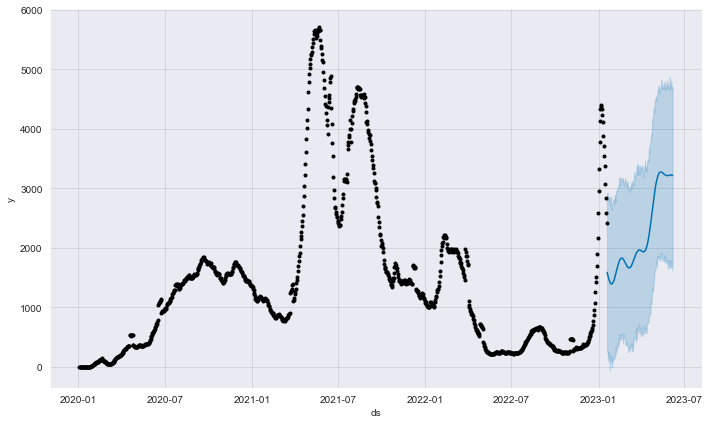

In [94]:
# Visualize predictions with uncertainty
prophet_model.plot(y_preds_prophet, uncertainty=True)
plt.show()

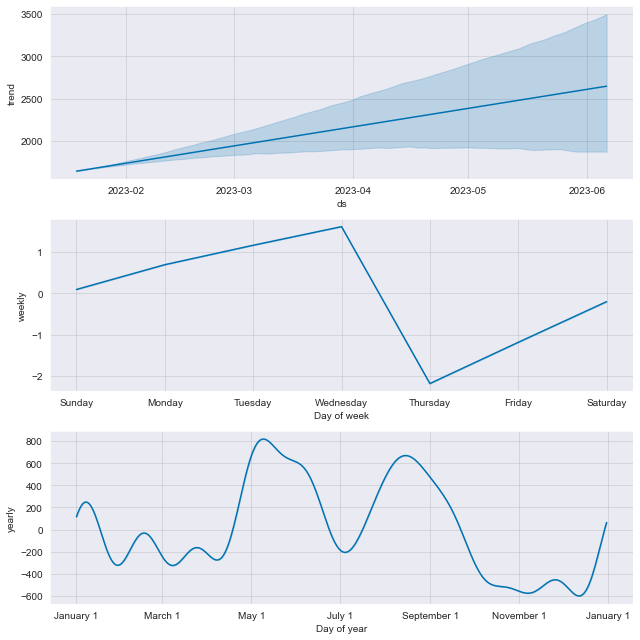

In [95]:
# Visualize trends
prophet_model.plot_components(y_preds_prophet)
plt.show()

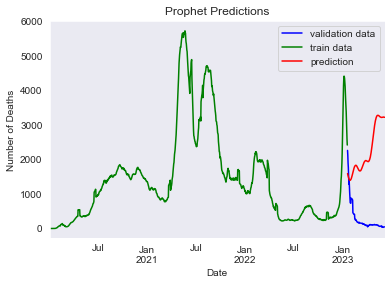

In [96]:
# Visualize Predictions (again)
graph_preds(y_train, y_val, y_preds_prophet['yhat'], 'Prophet')

In [97]:
# RMSE
evaluate(y_val, y_preds_prophet['yhat'], all_results, 'Prophet')

Prophet RMSE 2164.1


## Model 6 - Multivariate Prophet

Again, let's see if we can improve the model by including the other variables in our dataset.

In [98]:
# format data
train_prophet_multi = pd.concat([train_prophet, X_train.reset_index().drop('date', axis=1)], axis=1)
train_prophet_multi.head()

,ds,y,new_cases_smoothed,people_vaccinated,new_vaccinations_smoothed,stringency_index
0,2020-01-03,0.0,0.0,0.0,0.0,0.413830
1,2020-01-04,0.0,0.0,0.0,0.0,0.413830
2,2020-01-05,0.0,0.0,0.0,0.0,0.472979
3,2020-01-06,0.0,0.0,0.0,0.0,0.709362
4,2020-01-07,0.0,0.0,0.0,0.0,0.768511


In [99]:
# create model
prophet_multi = Prophet(interval_width=0.95)

# Add Regressors for multivariate 
for var in X_train.columns:
    prophet_multi.add_regressor(var, standardize=False)

# Fit Model
prophet_multi.fit(train_prophet_multi)

07:08:18 - cmdstanpy - INFO - Chain [1] start processing
07:08:18 - cmdstanpy - INFO - Chain [1] done processing
07:08:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
07:08:19 - cmdstanpy - INFO - Chain [1] start processing
07:08:31 - cmdstanpy - INFO - Chain [1] done processing


In [100]:
# Format Validation Data
val_prophet_multi = pd.concat([val_prophet[['ds']], X_val.reset_index().drop('date', axis=1)], axis=1)
val_prophet_multi.head()

,ds,new_cases_smoothed,people_vaccinated,new_vaccinations_smoothed,stringency_index
0,2023-01-19,334323.430,3.661146e+09,2263131.0,0.0
1,2023-01-20,293474.715,3.661156e+09,2269036.0,0.0
2,2023-01-21,262284.714,3.661165e+09,2301769.0,0.0
3,2023-01-22,234763.715,3.661173e+09,2364924.0,0.0
4,2023-01-23,213934.002,3.661177e+09,2022023.0,0.0


In [101]:
# predict using future dates
y_preds_prophet_multi = prophet_multi.predict(val_prophet_multi)

y_preds_prophet_multi.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-19,4640.043702,-318.881001,2172.069944,4640.043702,4640.043702,-3722.871014,-3722.871014,-3722.871014,-3768.951105,...,-1.369467,-1.369467,-1.369467,47.449558,47.449558,47.449558,0.0,0.0,0.0,917.172688
1,2023-01-20,4644.384588,-434.344731,2138.782582,4644.384462,4644.384588,-3780.203301,-3780.203301,-3780.203301,-3791.175911,...,1.017991,1.017991,1.017991,9.954619,9.954619,9.954619,0.0,0.0,0.0,864.181287
2,2023-01-21,4648.725473,-374.732426,2044.862597,4648.719243,4648.726564,-3834.801901,-3834.801901,-3834.801901,-3805.261953,...,0.761999,0.761999,0.761999,-30.301948,-30.301948,-30.301948,0.0,0.0,0.0,813.923572
3,2023-01-22,4653.066359,-574.006542,1989.340812,4653.051695,4653.077966,-3886.307087,-3886.307087,-3886.307087,-3814.185512,...,0.070439,0.070439,0.070439,-72.192013,-72.192013,-72.192013,0.0,0.0,0.0,766.759272
4,2023-01-23,4657.407244,-567.982029,1949.320763,4657.382569,4657.428650,-3975.433925,-3975.433925,-3975.433925,-3860.888022,...,0.035987,0.035987,0.035987,-114.581890,-114.581890,-114.581890,0.0,0.0,0.0,681.973319


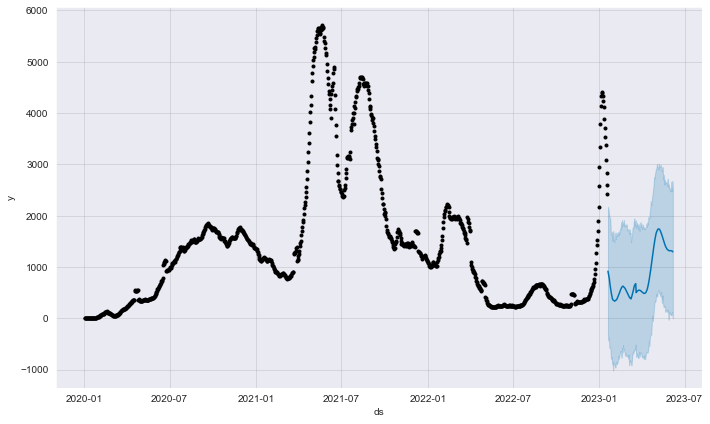

In [102]:
# Visualize predictions with uncertainty
prophet_multi.plot(y_preds_prophet_multi, uncertainty=True)
plt.show()

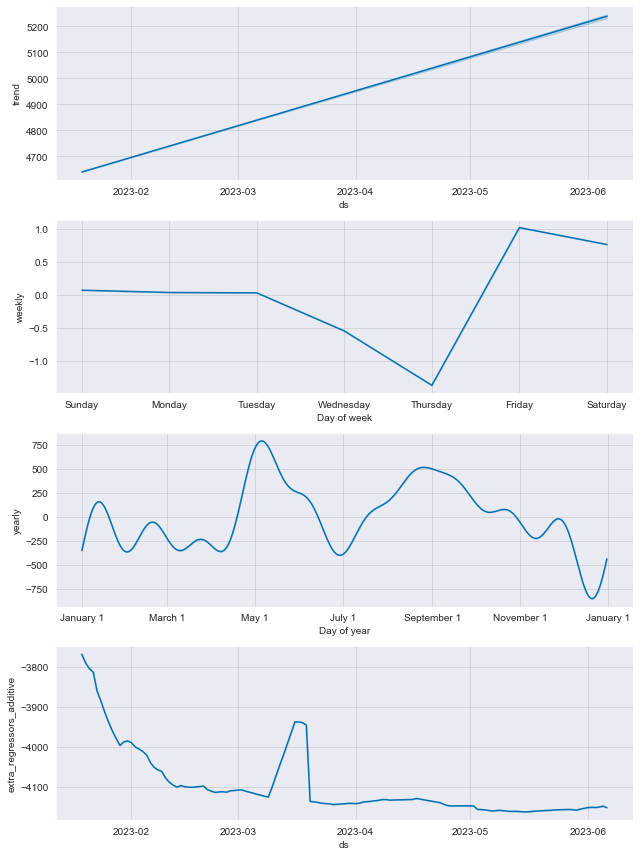

In [103]:
# Visualize Trends
prophet_multi.plot_components(y_preds_prophet_multi)
plt.show()

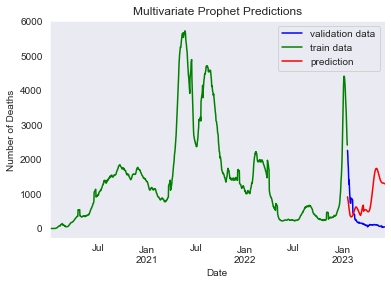

In [104]:
# Visualize predictions (again)
graph_preds(y_train, y_val, y_preds_prophet_multi['yhat'], 'Multivariate Prophet')

In [105]:
# RMSE
evaluate(y_val, y_preds_prophet_multi['yhat'], all_results, 'Prophet Multivariate')

Prophet Multivariate RMSE 904.5


## All Model Comparison

In [106]:
all_results_df = pd.DataFrame.from_dict(all_results)
all_results_df

,model,rmse
0,Naive,2342.568668
1,ARIMA,1943.663338
2,ARIMA Multivariate,968.171014
3,Linear Regression,808.503558
4,Prophet,2164.064851
5,Prophet Multivariate,904.498272


As we can see that all of our models that included further information, the models that did not rely solely on the number of deaths per day, had better results when forecasting. This is intuitive -- more information available generally leads to a better predictive model. 

We will move forward with the Multivariate Prophet Model as our final model. While the Linear Regression model has a slightly better RMSE, it is forecasting negative values for our test dates which is unreasonable for our situation. The Multivariate Prophet model, more suited to time series, is predicting positive values.  

# Final Model Evaluation

Now that we have chosen our final model we can evaluate it on the hold out test set.

In [107]:
# format data
train_all = pd.concat([train, validate])

y_train_all = train_all[['new_deaths_smoothed']].reset_index()
y_train_all.rename(columns={'date': 'ds', 'new_deaths_smoothed':'y'}, inplace=True)

X_train_all = train_all[['new_cases_smoothed', 'people_vaccinated', 'new_vaccinations_smoothed', 'stringency_index']]

train_all_prophet = pd.concat([y_train_all,
                               X_train_all.reset_index().drop('date', axis=1)],
                              axis=1)

In [108]:
# Create final model
prophet_final = Prophet(interval_width=0.95)

# Add Regressors for multivariate
for var in X_train.columns:
    prophet_final.add_regressor(var, standardize=False)
    
# Fit Model
prophet_final.fit(train_all_prophet)

07:08:37 - cmdstanpy - INFO - Chain [1] start processing
07:08:37 - cmdstanpy - INFO - Chain [1] done processing
07:08:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
07:08:38 - cmdstanpy - INFO - Chain [1] start processing
07:09:06 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
# Format Test Data
y_test_prophet = test[['new_deaths_smoothed']].reset_index()
y_test_prophet.rename(columns={'date':'ds','new_deaths_smoothed':'y'}, inplace=True)

X_test = test[['new_cases_smoothed', 'people_vaccinated', 'new_vaccinations_smoothed', 'stringency_index']]

test_prophet = pd.concat([y_test_prophet, X_test.reset_index().drop('date', axis=1)], axis=1)
test_prophet.head()

,ds,y,new_cases_smoothed,people_vaccinated,new_vaccinations_smoothed,stringency_index
0,2023-06-07,48.427,21120.573,3.676897e+09,328635.0,0.0
1,2023-06-08,48.143,19774.145,3.676899e+09,311378.0,0.0
2,2023-06-09,46.859,19821.574,3.676900e+09,300382.0,0.0
3,2023-06-10,45.858,22500.143,3.676901e+09,289305.0,0.0
4,2023-06-11,58.002,25346.713,3.676903e+09,274783.0,0.0


In [110]:
# Predict
y_preds_final = prophet_final.predict(test_prophet)

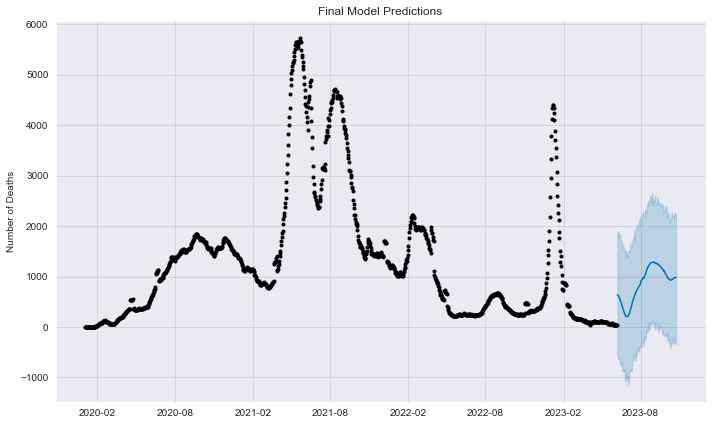

In [111]:
# Visualize predictions with uncertainty
prophet_final.plot(y_preds_final, uncertainty=True)
plt.title('Final Model Predictions')
plt.xlabel('')
plt.ylabel('Number of Deaths')
plt.show()

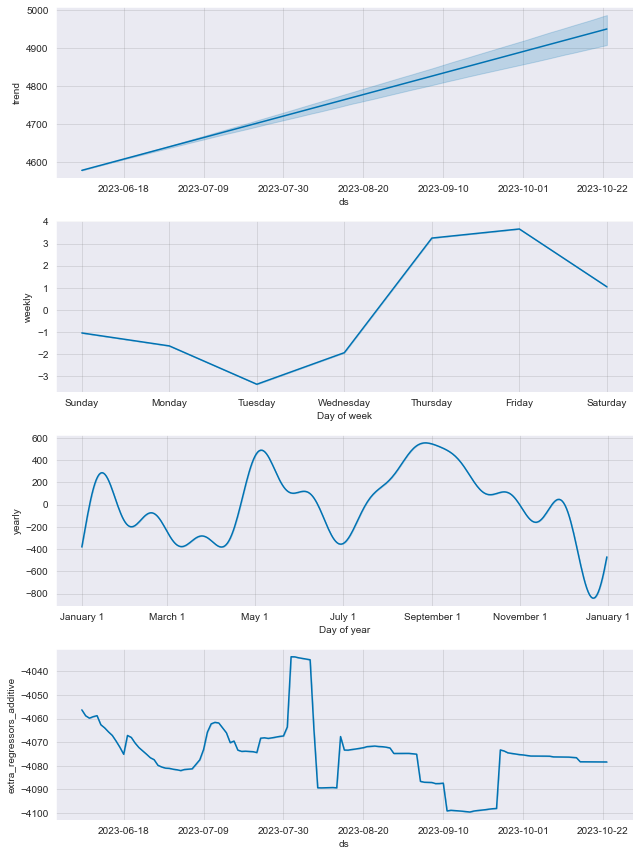

In [112]:
# Visualize trends
prophet_final.plot_components(y_preds_final)
plt.show()

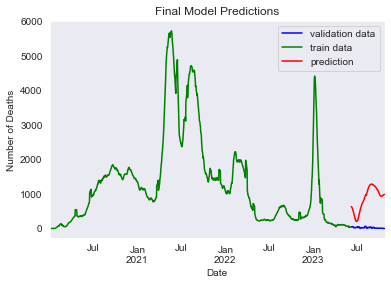

In [113]:
# Visualize predictions
graph_preds(train_all['new_deaths_smoothed'], 
            test['new_deaths_smoothed'], 
            y_preds_final['yhat'],
            'Final Model')

In [114]:
# RMSE Final
round(mean_squared_error(test['new_deaths_smoothed'], y_preds_final['yhat'], squared=True),2)

817900.07

Our model performed better on the validation data than it did on the test data.  In part, this is because the pandemic had more or less ended by this time (mid 2023), which means the actual values for our data lie very close to zero, whereas our model is predicting the deaths to increase once again (similar to the actuals of July in 2020).  

With an ending root mean squared error of 817,900 I would say this is a fairly good model, taking into account that this estimation is for the whole continent of Asia rather than one country alone.  

# Conclusion + Recommendations

The recommendations for the business are as follows:

1. **See how we can make our data more accurate.**  As good as the WHO is at accumulating and cleanly storing data, there is always room for improvement.  The amount of missing data in the dataset that led to dropping so many variables is a prime example of how the data collection can be improved.  (Of course this is not always the fault of the collectors, as noted a few times in this notebook, it is known that some countries purposefully reported incorrect numbers when reporting on deaths due to Covid-19). 

2. **Utilize models like these ones in future epidemics or pandemics.**  Clearly, these predictive models can be quite useful.  If we can forecast how detrimental an outbreak will be, then public health officials will be more equipped (and motivated) to handle the situation.  They will be better prepared to implement policy changes to help curb the harmful affects of an outbreak, and ideally lessen the number of unnecessary deaths.  

3. **Investigate how to further incorporate changing public health policies into time series data.**  A big drawback of performing a time series model from this data was that interesting variables -- such as extreme poverty, diabetes prevalence, percent smokers, number of hospital beds per thousand people, population density, etc. -- were not viable to use in the time series prediction.  The variables were constant for all dates which means they had no implication on the modeling process.  However, these factors realistically play a role in the number of deaths caused by Covid-19.  Furthermore, realistically, these numbers do change over time and thus could be used for the time series forecasting. If they can be more accurate and versatile per reporting period, then we can create a more proficient predictive model. 

4. **Investigate why deaths tend to be reported higher on Fridays.** From both the multivariate prophet models (the final model and the model evaluated on the validation set), we can see a weekly trend where there is a spike in number of deaths on Fridays. It would be interesting to investigate why this is. Does it have to do with how the numbers are reported?  We were using smoothed data so that seems less likely.  Can we connect it to how and when people are contracting the disease?  Can we connect it to situational occurrences in hospitals?  Of course, to really dig into this phenomenon we would need to break the data up by country once again and investigate deeper from there. 

###  Next Steps

There is always more to do and try!  Below are some ideas for expanding on this project:

- Data by continent
    - compare predictive models by continent
    - compare how well each continent handled the pandemic
- Data by country
    - create regressive model that can predict number of deaths based on location (and other variables that were in dataset) *Not Time Series*
    - Time series by country and then create a user interface to choose country and date to forecast and then predicts number of deaths